In [1]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE
from aldiscore.constants.constants import STAT_SEP

In [2]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, label_df = utils.load_features(
    data_dir,
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)

print(feat_df.shape)
print(drop_df.shape)
print(label_df.shape)

Dropping 0 NaN rows...
(11431, 397)
(11431, 21)
(11431, 1)


In [3]:
feat_df.columns[feat_df.columns.str.contains("ratio")]

Index(['min.psa_score_ratio', 'max.psa_score_ratio', 'mean.psa_score_ratio',
       'std.psa_score_ratio', 'p1.psa_score_ratio', 'p5.psa_score_ratio',
       'p10.psa_score_ratio', 'p20.psa_score_ratio', 'p30.psa_score_ratio',
       'p40.psa_score_ratio', 'p50.psa_score_ratio', 'p60.psa_score_ratio',
       'p70.psa_score_ratio', 'p80.psa_score_ratio', 'p90.psa_score_ratio',
       'p95.psa_score_ratio', 'p99.psa_score_ratio', 'iqr.psa_score_ratio',
       'min.psa_gap_ratio', 'max.psa_gap_ratio', 'mean.psa_gap_ratio',
       'std.psa_gap_ratio', 'p1.psa_gap_ratio', 'p5.psa_gap_ratio',
       'p10.psa_gap_ratio', 'p20.psa_gap_ratio', 'p30.psa_gap_ratio',
       'p40.psa_gap_ratio', 'p50.psa_gap_ratio', 'p60.psa_gap_ratio',
       'p70.psa_gap_ratio', 'p80.psa_gap_ratio', 'p90.psa_gap_ratio',
       'p95.psa_gap_ratio', 'p99.psa_gap_ratio', 'iqr.psa_gap_ratio',
       'min.psa_stretch_ratio', 'max.psa_stretch_ratio',
       'mean.psa_stretch_ratio', 'std.psa_stretch_ratio',
       'p1.

In [ ]:
# from sklearn.model_selection import train_test_split

# train_idxs, test_idxs = train_test_split(
#     feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
# )
# test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
# print(len(train_idxs), len(test_idxs), len(valid_idxs))
# #
# X_train = feat_df.loc[train_idxs]
# X_test = feat_df.loc[test_idxs]
# X_valid = feat_df.loc[valid_idxs]
# y_train = label_df.loc[train_idxs].iloc[:, 0]
# y_test = label_df.loc[test_idxs].iloc[:, 0]
# y_valid = label_df.loc[valid_idxs].iloc[:, 0]

9144 1143 1144


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

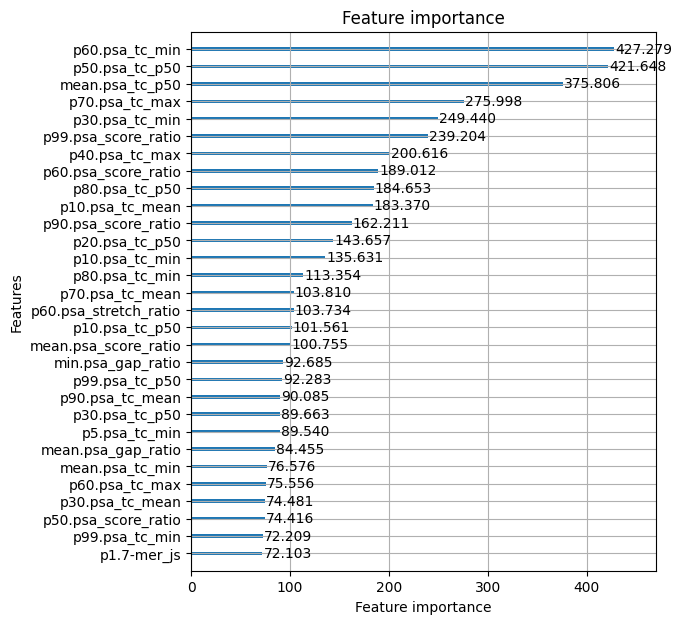

In [3]:
from aldiscore.prediction.predictor import DifficultyPredictor
import lightgbm as lgb

model = DifficultyPredictor("latest").model

feat_df = feat_df[model.feature_name()]
imps = model.feature_importance("gain")
lgb.plot_importance(model, figsize=(6, 7), importance_type="gain", max_num_features=30)

In [ ]:
sorted(list(model.params.keys()))
[
    "n_estimators",
    "colsample_bytree",
    "colsample_bynode",
    "min_data",
    "reg_alpha",
    "reg_lambda",
    "subsample",
]

col_mapping = {
    "n_estimators": "num_iterations",
    "colsample_bytree": "feature_fraction",
    "colsample_bynode": "feature_fraction_bynode",
    "learning_rate": "learning_rate",
    "min_data": "min_data_in_leaf",
    "num_leaves": "num_leaves",
    "lambda_l1": "lambda_l1",
    "lambda_l2": "lambda_l2",
    "subsample": "bagging_fraction",
}
pd.DataFrame(model.params)["n_estimators"]

KeyError: 'n_estimators'

In [ ]:
imp_df = pd.concat([pd.Series(model.feature_name()), pd.Series(imps)], axis=1)
imp_df.columns = ["name", "gain"]
imp_df
imp_df["group"] = pd.Series(imp_df.name.str.split(".").map(lambda v: v[-1]))
imp_df.sort_values("gain", ascending=False)
print(set(imp_df.group))
for pat in [
    "mean",
    "min",
    "max",
    "mean",
    "iqr",
    "p50",
    "std",
    # "count",
    # "len",
    # "len_logdiff",
]:
    imp_df.group = imp_df.group.str.rsplit("_" + pat).map(lambda v: v[0])
groups = set(imp_df.group)
groups

{'psa_gap_len_std', 'char_js', 'psa_tc_mean', '4-mer_js', 'psa_tc_min', 'lbgp', 'psa_stretch_ratio', '10-mer_ent', 'char_ent', 'psa_gap_ratio', 'psa_tc_std', 'psa_gap_len_mean', 'psa_tc_max', '13-mer_ent', 'hpoly_js_len', '7-mer_ent', 'psa_score_ratio', '7-mer_js', 'psa_tc_p50', '4-mer_ent', 'hpoly_js_count'}


{'10-mer_ent',
 '13-mer_ent',
 '4-mer_ent',
 '4-mer_js',
 '7-mer_ent',
 '7-mer_js',
 'char_ent',
 'char_js',
 'hpoly_js_count',
 'hpoly_js_len',
 'lbgp',
 'psa_gap_len',
 'psa_gap_ratio',
 'psa_score_ratio',
 'psa_stretch_ratio',
 'psa_tc'}

In [9]:
# imp_df.loc[imp_df.name.str.contains("gap_len")].sort_values(
#     "gain", ascending=False
# ).iloc[:20]
rel = imp_df["gain"] / imp_df["gain"].sum()
print(rel.min(), rel.max())
imp_df.loc[rel > 0.001].sort_values("gain", ascending=False)

8.505058387052136e-05 0.05554504496075893


,name,gain,group
84,p60.psa_tc_min,427.279456,psa_tc
155,p50.psa_tc_p50,421.647781,psa_tc
147,mean.psa_tc_p50,375.806266,psa_tc
139,p70.psa_tc_max,275.998185,psa_tc
81,p30.psa_tc_min,249.439630,psa_tc
...,...,...,...
310,std.7-mer_ent,8.336826,7-mer_ent
6,p5.char_ent,8.330233,char_ent
240,p5.psa_gap_len_std,7.960949,psa_gap_len
289,min.7-mer_js,7.816244,7-mer_js


In [12]:
model.feature_importance()

array([287, 140, 132, 105, 159, 112, 118, 114, 138, 131, 124, 127, 149,
       135, 124, 120, 139, 114, 185, 112, 137, 134, 150, 159, 102,  95,
       122, 134, 146, 129, 145, 127, 129, 130, 117, 155, 148, 143, 130,
        89, 147, 141, 132, 135, 108, 115, 111, 128, 114, 113, 106,  88,
       131, 122, 134, 107, 135, 122, 129, 116, 153, 138, 162, 154, 146,
       123, 153, 113, 137, 123, 106, 126, 164,  88, 105, 145, 118, 109,
       103, 132, 112, 131, 118, 130, 170, 162, 145, 121, 139, 110, 155,
        85, 110, 130, 159,  99, 111, 106, 145, 118, 128, 144, 138, 150,
       151,  87, 113, 116, 147,  96, 178, 184, 146,  93,  90, 120, 149,
       147, 138, 169, 180, 187, 168, 141, 163, 139, 156, 111,  81, 127,
       167,  90, 112, 100, 122, 138, 140, 106, 152, 125, 109, 110,  93,
       101, 130,  77,  95, 157, 133,  92, 126, 116, 118, 130, 127, 147,
       129, 169, 150, 144, 135, 105, 161, 138, 167, 188, 195, 140, 146,
       150, 176, 161, 161, 194, 158, 170, 176, 221, 181, 192, 18

In [16]:
stat_df = imp_df.drop("name", axis=1).groupby("group").aggregate(["sum", "count"])
T_GAIN = "Gain (%)"
# M_GAIN = "mean_gain (%)"
stat_df.columns = [T_GAIN, "Count"]
stat_df = stat_df.sort_values(T_GAIN, ascending=False)
gain_cols = [T_GAIN]
stat_df[gain_cols] = (stat_df[gain_cols] / stat_df[gain_cols].sum(axis=0)).round(
    4
) * 100
stat_df

,Gain (%),Count
group,,
psa_tc,63.23,90
psa_score_ratio,13.13,18
psa_gap_ratio,5.55,18
psa_stretch_ratio,3.95,18
psa_gap_len,3.05,36
7-mer_js,2.78,18
char_js,1.45,18
4-mer_js,1.34,18
10-mer_ent,1.23,18


In [17]:
# name_map = dict(
#     tc_base="psa_tc",
# )
# for i in [5, 7, 9, 11]:
#     for sfx in ["ent", "js"]:
#         name_map[f"{i}mer_{sfx}"] = f"{i}-mer_{sfx}"
# name_map["js_char"] = "char_js"
# name_map["ent_char"] = "char_ent"
# name_map["js_hpoly_len"] = "hpoly_js_len"
# name_map["js_hpoly_count"] = "hpoly_js_count"
# stat_df = stat_df.rename(name_map)

In [22]:
stat_df["Description"] = ""

stat_df.at["psa_tc", "Description"] = "Transitive consistency of PSA triplets."
stat_df.at["psa_score_ratio", "Description"] = (
    "Alignment score scaled by the minimum sequence length."
)
stat_df.at["psa_gap_ratio", "Description"] = (
    "Number of gaps divided by total number of characters."
)
stat_df.at["psa_gap_len", "Description"] = (
    "Features based on the lengths of gap regions."
)
stat_df.at["char_ent", "Description"] = "Shannon entropy of character distributions."
stat_df.at["char_js", "Description"] = (
    "Pairwise Jensen-Shannon divergence of character distributions."
)
stat_df.at["psa_stretch_ratio", "Description"] = (
    "Ratio between max. sequence length and alignment length."
)
stat_df.at["hpoly_js_len", "Description"] = (
    "Pairwise Jensen-Shannon divergence of homopolymer length distributions."
)
stat_df.at["hpoly_js_count", "Description"] = (
    "Pairwise Jensen-Shannon divergence of homopolymer count distributions."
)
stat_df.at["lbgp", "Description"] = (
    "Lower bound on the gap percentage (1 - mean_len/max_len)."
)
for i in [4, 7, 10, 13]:
    if i < 10:
        stat_df.at[f"{i}-mer_js", "Description"] = (
            f"Pairwise Jensen-Shannon divergence of {i}-mer distributions."
        )
    stat_df.at[f"{i}-mer_ent", "Description"] = (
        f"Shannon entropy of {i}-mer distributions."
    )
stat_df.index.name = "Feature Group"
print(stat_df.to_latex(escape=True, float_format="%.2f"))

\begin{tabular}{lrrl}
\toprule
 & Gain (\%) & Count & Description \\
Feature Group &  &  &  \\
\midrule
psa\_tc & 63.23 & 90 & Transitive consistency of PSA triplets. \\
psa\_score\_ratio & 13.13 & 18 & Alignment score scaled by the minimum sequence length. \\
psa\_gap\_ratio & 5.55 & 18 & Number of gaps divided by total number of characters. \\
psa\_stretch\_ratio & 3.95 & 18 & Ratio between max. sequence length and alignment length. \\
psa\_gap\_len & 3.05 & 36 & Features based on the lengths of gap regions. \\
7-mer\_js & 2.78 & 18 & Pairwise Jensen-Shannon divergence of 7-mer distributions. \\
char\_js & 1.45 & 18 & Pairwise Jensen-Shannon divergence of character distributions. \\
4-mer\_js & 1.34 & 18 & Pairwise Jensen-Shannon divergence of 4-mer distributions. \\
10-mer\_ent & 1.23 & 18 & Shannon entropy of 10-mer distributions. \\
char\_ent & 0.97 & 18 & Shannon entropy of character distributions. \\
13-mer\_ent & 0.94 & 18 & Shannon entropy of 13-mer distributions. \\
7-mer\_en

In [22]:
# Feature classes:
# - tc_base :
# - psa_score_ratio : Alignment score scaled by the minimum sequence length
# - kmer_js : Pairwise Jensen-Shannon divergence of kmer distributions
# - kmer_ent : Entropy of kmer distributions
# - lbgp : Lower bound on the percentage of gaps
# - psa_gap :